In [1]:

import pandas as pd
import numpy as np
import h5py
import scipy.io
import scipy.stats as stats
np.random.seed(1337) # for reproducibility

import keras.backend as K
from keras.models import Model, load_model

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IntegratedGradients import *
from util_funcs import *
from plotseqlogo import seqlogo, seqlogo_fig

import pandas as pd
import sklearn
from sklearn import preprocessing

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import model_utils

Using TensorFlow backend.


2021-04-14 11:38:32,091 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

## Defining Functions

In [3]:
# Functions from Seelig to make predictions with Seelig Model

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    predictions = model.predict(test_seq).reshape(-1)
    
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])
    
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

# <font color = pink> Load Data & Train Model with Human 5'UTRs</font>

In [11]:
df = pd.read_csv('/home/fkorbel/manuscript/data/seelig/human_50.csv')
df = sklearn.utils.shuffle(df)
test_seq, test, train_seq, train = model_utils.build_datasets(df, 
                                                              seq_column = 'utr', 
                                                              te_column = 'rl',
                                                              min_utr_length = 50,
                                                              max_utr_length = 50,
                                                                use_sklearn = False)

/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/model_utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][i] = (number * 'N') + data[column][i]


In [12]:

train_scaler = preprocessing.StandardScaler()
test_scaler = preprocessing.StandardScaler()
train.loc[:,'scaled_rl'] = train_scaler.fit_transform(train.loc[:,'rl'].values.reshape(-1,1))
test.loc[:,'scaled_rl'] = test_scaler.fit_transform(test.loc[:,'rl'].values.reshape(-1,1))

In [13]:
model = model_utils.create_cnn(
    inp_len = 50,
    dense_layers = 1,
    nodes = 40,
    layers = 3,
    filter_len = [8,8,8],
    nbr_filters = [120,120,120],
    dropout3 = 0.2,
    pool_bool = False,
)

In [14]:
model_utils.train_model(model,
                       train_seq,
                       train['scaled_rl'],
                       test_seq,
                       test['scaled_rl'],
                       nb_epochs = 10,
                       batch = 128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.7129 - val_loss: 0.3404
Epoch 2/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.3061 - val_loss: 0.2761
Epoch 3/10
20000/20000 [==============================] - 1s 57us/step - loss: 0.2665 - val_loss: 0.2538
Epoch 4/10
20000/20000 [==============================] - 1s 61us/step - loss: 0.2350 - val_loss: 0.2388
Epoch 5/10
20000/20000 [==============================] - 1s 62us/step - loss: 0.2071 - val_loss: 0.2372
Epoch 6/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.1821 - val_loss: 0.2270
Epoch 7/10
20000/20000 [==============================] - 1s 65us/step - loss: 0.1568 - val_loss: 0.2318
Epoch 8/10
20000/20000 [==============================] - 1s 66us/step - loss: 0.1378 - val_loss: 0.2223
Epoch 9/10
20000/20000 [==============================] - 1s 65us/step - loss: 0.1203 - val_loss: 0.2363
Epoch 

(0.7761799961879321, <Figure size 432x288 with 1 Axes>)

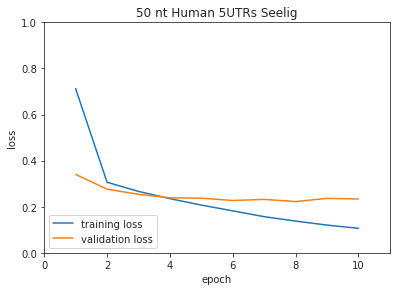

In [15]:
test = model_utils.make_prediction(model, test_scaler, test, test_seq, output_column = 'pred')

model_utils.test_model(test, 
           model,
           te_column = 'rl',
           pred_column = 'pred',
           title = '50 nt Human 5UTRs Seelig')

(0.881010780971454, 0.0)

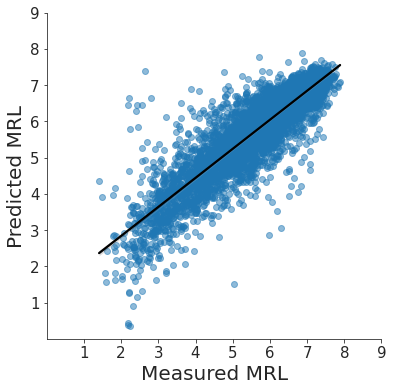

In [17]:
sns.set_style('ticks')
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()
scipy.stats.pearsonr(test['rl'], test['pred'])

In [19]:
#model.save('/home/fkorbel/manuscript/data/models/human_MRL_model.hdf5')

In [18]:
#train.to_csv('/home/fkorbel/manuscript/data/seelig/human_50_train.csv')
#test.to_csv('/home/fkorbel/manuscript/data/seelig/pred_hMRL_human_50.csv')

In [4]:
model = keras.models.load_model('/home/fkorbel/manuscript/data/models/human_MRL_model.hdf5')

2021-04-14 11:40:13,203 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2021-04-14 11:40:13,205 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2021-04-14 11:40:13,256 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2021-04-14 11:40:13,257 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-04-14 11:40:13,264 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-04-14 11:40:13,295 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2021-04-14 11:40:13,296 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2021-04-14 11:40:13,297 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2021-04-14 11:40:13,465 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2021-04-14 11:40:13,466 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2021-04-14 11:40:13,720 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2021-04-14 11:40:14,101 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2021-04-14 11:40:14,182 [WARNING] From /home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [5]:
test = pd.read_csv('/home/fkorbel/manuscript/data/seelig/human_50_test.csv')

# <font color = pink> Integrated Gradients </font>

In [24]:
ig = integrated_gradients(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/home/fkorbel/anaconda3/envs/integrated_grads/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


## <font color = pink> Highest and lowest predicted MRL </font>

In [25]:
e_test = pd.read_csv('/home/fkorbel/manuscript/data/seelig/random_50_test.csv')  #the 20k utr with most reads are the test set

seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,'rl'].values.reshape(-1,1))

e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)

In [ ]:
e_test.to_csv('/home/fkorbel/manuscript/data/seelig/pred_hMRL_random_50.csv', index = False)

(0.8625157108147338, 0.0)

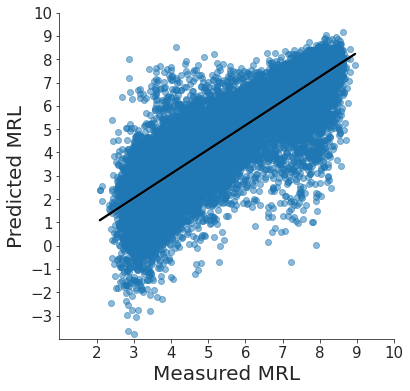

In [26]:
sns.set_style('ticks')
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = e_test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(-4,10), xlim=(1,10), xticks = range(2,11,1), yticks = range(-3,11,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()
scipy.stats.pearsonr(e_test['rl'], e_test['pred'])

In [27]:

#Getting the sequences with highest predicted and lowest predicted MRL value
pred_sorted = e_test['pred'].sort_values(ascending=False)
highest_ten=pred_sorted[:10]
lowest_ten=pred_sorted.iloc[19990:]
ind_high=highest_ten.index
ind_low=lowest_ten.index

#Applying IGs
highest_ex=np.array([ig.explain(seq_e_test[i]) for i in ind_high])
lowest_ex=np.array([ig.explain(seq_e_test[i]) for i in ind_low])


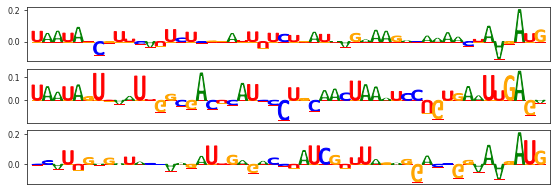

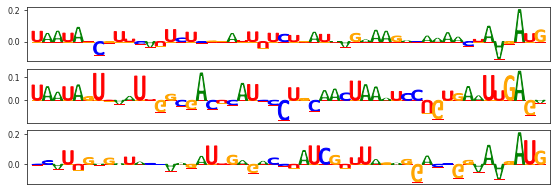

In [54]:
seqlogo_fig(np.transpose(highest_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

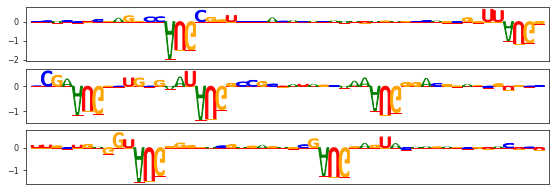

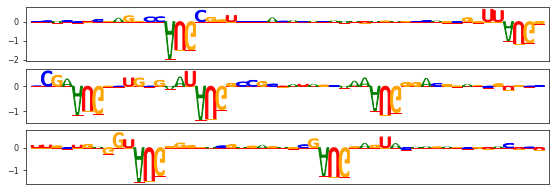

In [29]:
seqlogo_fig(np.transpose(lowest_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

## <font color = pink> Highest and lowest Error </font>

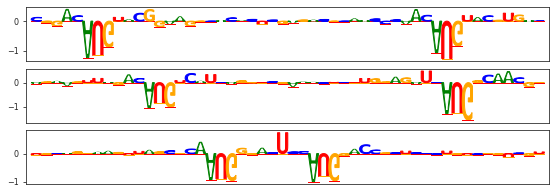

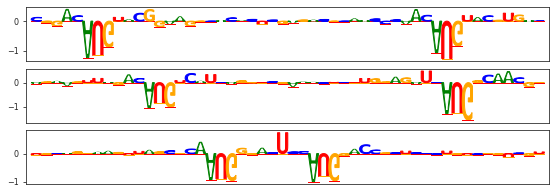

In [30]:
#Getting the sequences with the greatest discrepancy between predicted and measured MRL
top_10_max_diff = ((e_test['rl'] - e_test['pred']).abs()).sort_values(ascending=False)[:10]
ind_10_max_diff = top_10_max_diff.index

#Applying IGs
max_diff_ex=np.array([ig.explain(seq_e_test[i]) for i in ind_10_max_diff])

#Generating Sequence Logo Figures
seqlogo_fig(np.transpose(max_diff_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [31]:
obs_mrl = [e_test['rl'][i] for i in ind_10_max_diff]
pred_mrl = [e_test['pred'][i] for i in ind_10_max_diff]

overview_mrls = np.transpose(pd.DataFrame([ind_10_max_diff,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
3908.0,7.221381,-0.703959
17075.0,7.896025,0.014873
2405.0,7.816275,1.000902
4710.0,7.805286,1.019446
1495.0,3.003022,-3.773124
5628.0,2.845167,-3.650147
17596.0,7.066285,0.607293
9010.0,7.933983,1.476053
13008.0,6.615994,0.173678


/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


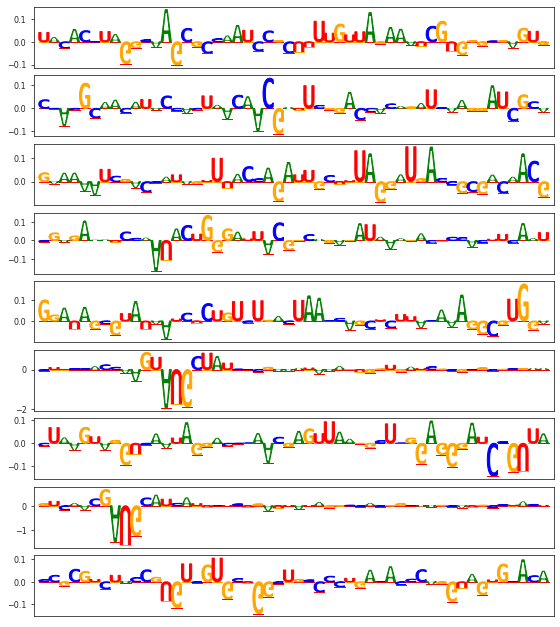

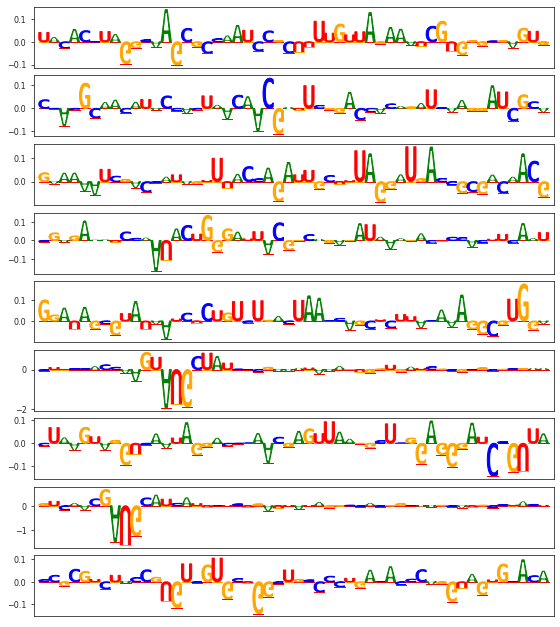

In [32]:
#Getting the sequences with the greatest discrepancy between predicted and measured MRL
top_10_min_diff = ((e_test['rl'] - e_test['pred']).abs()).sort_values(ascending=True)[:10]
ind_10_min_diff = top_10_min_diff.index

#Applying IGs
min_diff_ex=np.array([ig.explain(seq_e_test[i]) for i in ind_10_min_diff])

#Generating Sequence Logo Figures
seqlogo_fig(np.transpose(min_diff_ex[:9], axes=(1,2,0)), vocab='RNA', figsize=(8,9), ncol=1)

In [33]:
obs_mrl = [e_test['rl'][i] for i in ind_10_min_diff]
pred_mrl = [e_test['pred'][i] for i in ind_10_min_diff]

overview_mrls = np.transpose(pd.DataFrame([ind_10_min_diff,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
18946.0,8.073458,8.073427
3250.0,7.696397,7.696444
5112.0,8.123064,8.123150
18874.0,7.882229,7.882371
8410.0,8.286485,8.286242
9441.0,3.483459,3.483797
13177.0,6.805112,6.804763
2352.0,2.579845,2.580216
11063.0,7.137957,7.138444


## <font color = pink> Integrated Grads for False Positives and False Negatives </font>

In [34]:
#Defining False Positives: high pred - low obs
fp = ((e_test['pred'] - e_test['rl'])).sort_values(ascending=False)[:20]
fp_ind = fp.index
      
#Defining False Negatives: low pred - high obs
fn = ((e_test['rl'] - e_test['pred'])).sort_values(ascending=False)[:20]
fn_ind = fn.index
      
#Applying IGs
fp_ex=np.array([ig.explain(seq_e_test[i]) for i in fp_ind])
fn_ex=np.array([ig.explain(seq_e_test[i]) for i in fn_ind])
      

/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


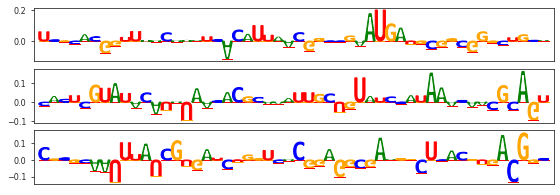

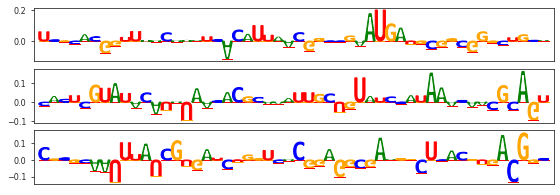

In [35]:
seqlogo_fig(np.transpose(fp_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [36]:
obs_mrl = [e_test['rl'][i] for i in fp_ind]
pred_mrl = [e_test['pred'][i] for i in fp_ind]

overview_mrls = np.transpose(pd.DataFrame([fp_ind,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
13096.0,2.862142,7.992667
18152.0,4.127045,8.530623
18481.0,2.870973,7.196770
3582.0,3.419108,7.584475
3974.0,3.598649,7.614545
8461.0,3.701647,7.715761
13731.0,3.604835,7.456995
12884.0,2.891727,6.586853
11786.0,2.677383,6.363233


/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


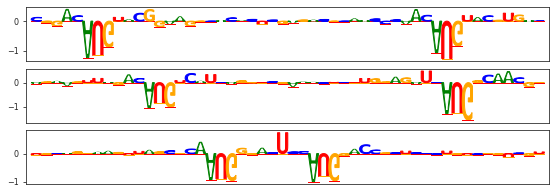

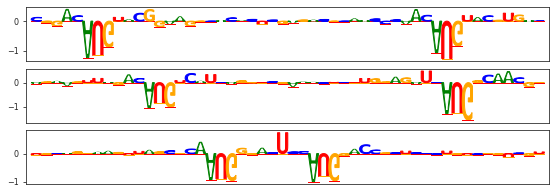

In [37]:
seqlogo_fig(np.transpose(fn_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [38]:
obs_mrl = [e_test['rl'][i] for i in fn_ind]
pred_mrl = [e_test['pred'][i] for i in fn_ind]

overview_mrls = np.transpose(pd.DataFrame([fn_ind,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
3908.0,7.221381,-0.703959
17075.0,7.896025,0.014873
2405.0,7.816275,1.000902
4710.0,7.805286,1.019446
1495.0,3.003022,-3.773124
5628.0,2.845167,-3.650147
17596.0,7.066285,0.607293
9010.0,7.933983,1.476053
13008.0,6.615994,0.173678


# <font color = red> THE SAME ON HUMAN UTRs </font>

In [39]:
human = test

#one-hot encoding human utrs
oh_human = test_seq

#testing the model with human utrs
e_test = test_data(df=human, model=model, obs_col='rl',test_seq=oh_human)

## <font color = pink> Highest and lowest predicted MRL </font>

In [40]:
pred_sorted = e_test['pred'].sort_values(ascending=False)
top10 = pred_sorted.iloc[:10]
top10_ind = top10.index

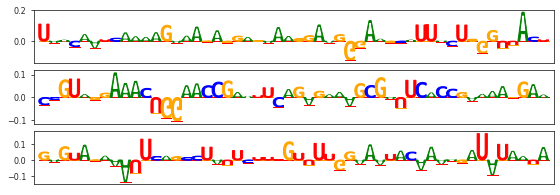

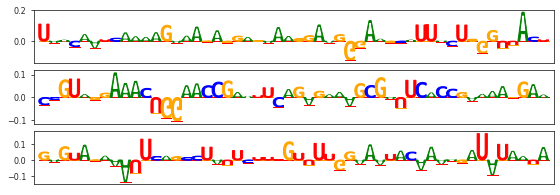

In [57]:
top10_ex = np.array([ig.explain(oh_human[i]) for i in top10_ind])
seqlogo_fig(np.transpose(top10_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [42]:
obs_mrl = [e_test['rl'][i] for i in top10_ind]
pred_mrl = [e_test['pred'][i] for i in top10_ind]

overview_mrls = np.transpose(pd.DataFrame([top10_ind,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
3809.0,6.860557,7.897721
4657.0,5.705457,7.776071
349.0,7.383888,7.690332
1456.0,6.910139,7.664906
1564.0,6.496519,7.634018
3896.0,7.442336,7.620298
748.0,7.662475,7.583741
3281.0,7.218234,7.570586
180.0,7.562135,7.548442


/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


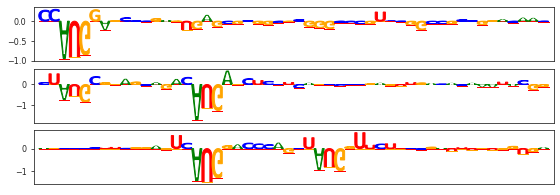

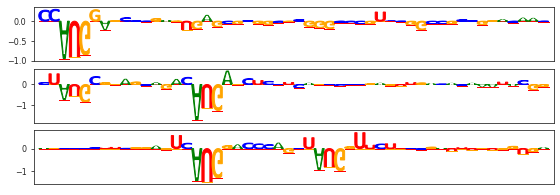

In [43]:
flop10_ex =np.array([ig.explain(oh_human[i]) for i in pred_sorted.iloc[4990:].index])
seqlogo_fig(np.transpose(flop10_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)


In [44]:
obs_mrl = [e_test['rl'][i] for i in pred_sorted.iloc[4990:].index]
pred_mrl = [e_test['pred'][i] for i in pred_sorted.iloc[4990:].index]

overview_mrls = np.transpose(pd.DataFrame([pred_sorted.iloc[4990:].index,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
1570.0,1.602610,1.575752
1768.0,5.045326,1.513629
3206.0,2.558725,1.313823
3823.0,2.210531,1.298994
2447.0,2.204839,1.267178
4542.0,2.435849,1.152453
2668.0,2.333015,0.911128
3983.0,2.178200,0.433744
1126.0,2.183076,0.370936


## <font color = pink> False Positives and False Negatives </font>

In [45]:
#Defining False Positives: high pred - low obs
fp = ((e_test['pred'] - e_test['rl'])).sort_values(ascending=False)[:10]
fp_ind = fp.index
      
#Defining False Negatives: low pred - high obs
fn = ((e_test['rl'] - e_test['pred'])).sort_values(ascending=False)[:10]
fn_ind = fn.index
      
#Applying IGs
fp_ex=np.array([ig.explain(oh_human[i]) for i in fp_ind])
fn_ex=np.array([ig.explain(oh_human[i]) for i in fn_ind])


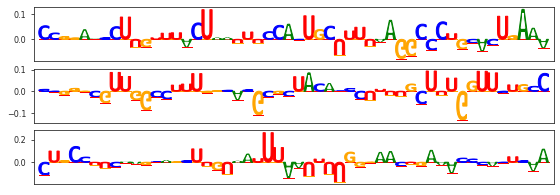

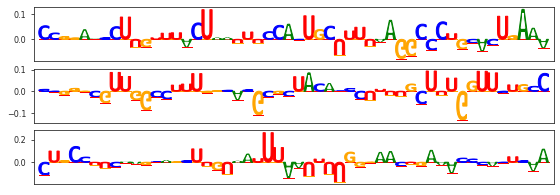

In [58]:
seqlogo_fig(np.transpose(fp_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [47]:
obs_mrl = [e_test['rl'][i] for i in fp_ind]
pred_mrl = [e_test['pred'][i] for i in fp_ind]

overview_mrls = np.transpose(pd.DataFrame([fp_ind,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
1811.0,2.645704,7.400007
2479.0,2.222096,6.637530
1833.0,2.190169,6.444438
4824.0,2.415710,6.455284
889.0,2.551704,6.454572
1506.0,2.392375,6.289566
2386.0,2.799026,6.634761
3594.0,2.249371,5.781140
4656.0,2.462927,5.846399


/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


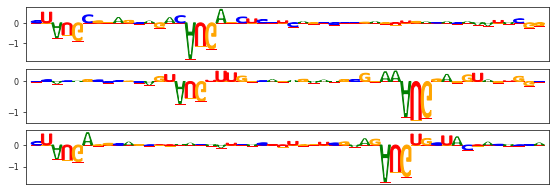

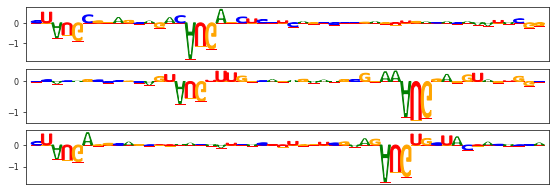

In [48]:
seqlogo_fig(np.transpose(fn_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

In [49]:
obs_mrl = [e_test['rl'][i] for i in fn_ind]
pred_mrl = [e_test['pred'][i] for i in fn_ind]

overview_mrls = np.transpose(pd.DataFrame([fn_ind,obs_mrl, pred_mrl], ['index','Observed MRL','Predicted MRL']))
overview_mrls.set_index('index')

,Observed MRL,Predicted MRL
index,,
1768.0,5.045326,1.513629
2904.0,6.299791,3.047090
503.0,5.978840,2.875087
1088.0,6.766773,4.044981
4102.0,6.193019,3.533709
3431.0,6.832332,4.203063
4363.0,6.525725,3.946905
2963.0,7.071539,4.647744
1212.0,6.559625,4.229042


## <font color = pink> H

/fast/home/f/fkorbel/manuscript/mpra/integrated_gradients/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


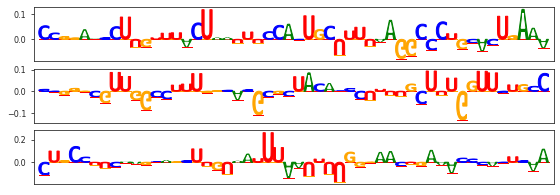

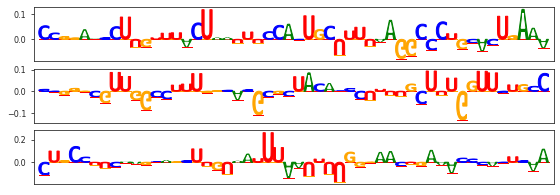

In [50]:
#Getting the sequences with the greatest discrepancy between predicted and measured MRL
top_10_max_diff = ((e_test['rl'] - e_test['pred']).abs()).sort_values(ascending=False)[:10]
ind_10_max_diff = top_10_max_diff.index

top_10_min_diff = ((e_test['rl'] - e_test['pred']).abs()).sort_values(ascending=True)[:10]
ind_10_min_diff = top_10_min_diff.index

#Applying IGs
max_diff_ex=np.array([ig.explain(oh_human[i]) for i in ind_10_max_diff])
min_diff_ex=np.array([ig.explain(oh_human[i]) for i in ind_10_min_diff])

#Generating Sequence Logo Figures
seqlogo_fig(np.transpose(max_diff_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)

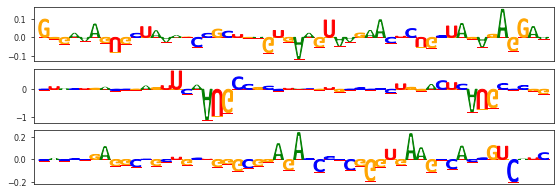

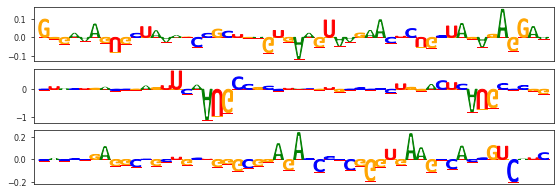

In [51]:
seqlogo_fig(np.transpose(min_diff_ex[:3], axes=(1,2,0)), vocab='RNA', figsize=(8,3), ncol=1)